In [50]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [51]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [52]:
waterDF = df[list(rename_map.keys())].copy()
waterDF.rename(columns=rename_map, inplace=True)

waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')
waterDF = waterDF.dropna(subset=['일자']).copy()
waterDF['월'] = waterDF['일자'].dt.month

waterDF.head()

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,월
0,물금,2021-01-04,4.6,7.5,437,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,1
1,물금,2021-01-11,2.8,7.3,461,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,1
2,물금,2021-01-26,5.1,7.2,470,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,1
3,물금,2021-01-18,3.1,7.3,463,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,1
4,물금,2021-02-16,6.6,8.4,451,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2


In [53]:
waterDF['지점'] = np.where(waterDF['총량지점명'].str.contains('물금', na=False), '물금',
                    np.where(waterDF['총량지점명'].str.contains('금곡', na=False), '금곡', np.nan))

num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

waterDF = waterDF.dropna(subset=['지점']).copy()
waterDF['계절'] = np.where(waterDF['월'].between(6, 9), '여름', '비여름')

summerDF = waterDF[waterDF['계절']=='여름'].copy()
summer_mulgum = summerDF[summerDF['지점']=='물금'].copy()
summer_geumgok = summerDF[summerDF['지점']=='금곡'].copy()

print("여름 물금:", len(summer_mulgum), "여름 금곡:", len(summer_geumgok))


여름 물금: 81 여름 금곡: 61


In [54]:
target = '클로로필-a'
corr_cols = ['수온','전기전도도(EC)','용존산소(DO)','BOD','COD','부유물질',
            '총질소(T-N)','총인(T-P)','총유기탄소(TOC)','유량', target]

mulgum_corr = summer_mulgum[corr_cols].dropna().corr(method='spearman')[target].sort_values(ascending=False)
geumgok_corr = summer_geumgok[corr_cols].dropna().corr(method='spearman')[target].sort_values(ascending=False)

print("[물금]\n", mulgum_corr)
print("\n[금곡]\n", geumgok_corr)


[물금]
 클로로필-a        1.000000
BOD           0.623602
COD           0.495038
전기전도도(EC)     0.474684
용존산소(DO)      0.397265
수온            0.350482
총유기탄소(TOC)    0.260629
부유물질          0.047464
총인(T-P)      -0.514591
유량           -0.527660
총질소(T-N)     -0.545711
Name: 클로로필-a, dtype: float64

[금곡]
 클로로필-a        1.000000
BOD           0.665436
COD           0.493301
전기전도도(EC)     0.434869
용존산소(DO)      0.421779
수온            0.403589
총유기탄소(TOC)    0.172012
부유물질          0.049759
총질소(T-N)     -0.422339
총인(T-P)      -0.431941
유량           -0.545560
Name: 클로로필-a, dtype: float64


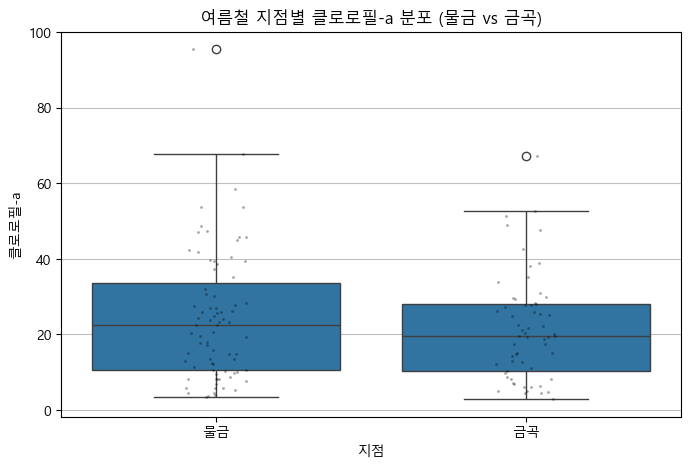

In [55]:
plt.figure(figsize=(8,5))
sb.boxplot(data=summerDF, x='지점', y='클로로필-a')
sb.stripplot(data=summerDF, x='지점', y='클로로필-a', color='black', alpha=0.35, size=2)
plt.title('여름철 지점별 클로로필-a 분포 (물금 vs 금곡)')
plt.xlabel('지점')
plt.ylabel('클로로필-a')
plt.grid(True, axis='y', alpha=0.8)
plt.show()


“여름철 클로로필-a 분포를 비교한 결과, 물금 지점은 금곡에 비해 중앙값이 높고 분산이 크며, 고농도 이상치가 다수 관측되어 녹조 발생의 강도와 변동성이 모두 큰 지점으로 나타났다.”

In [56]:
waterDF.dtypes.sort_values()

부유물질                 float64
일자            datetime64[ns]
월                      int32
수온                   float64
수소이온농도(ph)           float64
전기전도도(EC)            float64
용존산소(DO)             float64
BOD                  float64
COD                  float64
총질소(T-N)             float64
총인(T-P)              float64
총유기탄소(TOC)           float64
유량                   float64
클로로필-a               float64
총량지점명                 object
지점                    object
계절                    object
dtype: object

In [57]:

# 1) 숫자여야 하는 컬럼 목록 (현재 화면 기준)
num_cols = [
    '클로로필-a','유량','총유기탄소(TOC)','총인(T-P)','총질소(T-N)','부유물질',
    'COD','BOD','용존산소(DO)','전기전도도(EC)','수소이온농도(ph)','수온'
]

# 2) 문자열 정리(콤마/공백 제거, '-' 같은 결측 표기 처리)
for c in num_cols:
    if c in waterDF.columns:
        waterDF[c] = (waterDF[c].astype(str)
                              .str.replace(',', '', regex=False)
                              .str.strip()
                              .replace({'-': np.nan, '': np.nan, 'nan': np.nan}))

# 3) 숫자로 변환 (변환 불가 값은 NaN)
for c in num_cols:
    if c in waterDF.columns:
        waterDF[c] = pd.to_numeric(waterDF[c], errors='coerce')

# 4) 변환 결과 확인
waterDF[num_cols].dtypes


클로로필-a        float64
유량            float64
총유기탄소(TOC)    float64
총인(T-P)       float64
총질소(T-N)      float64
부유물질          float64
COD           float64
BOD           float64
용존산소(DO)      float64
전기전도도(EC)     float64
수소이온농도(ph)    float64
수온            float64
dtype: object

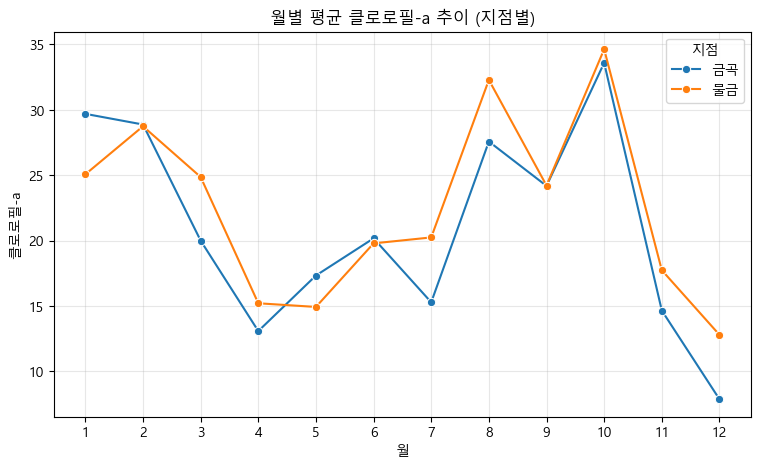

In [58]:
num_cols = waterDF.select_dtypes(include='number').columns
waterDF.groupby('총량지점명')[num_cols].mean()


monthly_site = (waterDF.groupby(['월','지점'])['클로로필-a'].mean().reset_index())

plt.figure(figsize=(9,5))
sb.lineplot(data=monthly_site, x='월', y='클로로필-a', hue='지점', marker='o')
plt.xticks(range(1,13))
plt.title('월별 평균 클로로필-a 추이 (지점별)')
plt.grid(True, alpha=0.3)
plt.show()


“월별 평균 클로로필-a는 여름철에 상승한 이후 가을(10월)에 최고치를 보였으며, 이는 고수온기에 축적된 영양염과 체류시간 증가가 녹조를 지연 증폭시키는 구조임을 시사한다.”

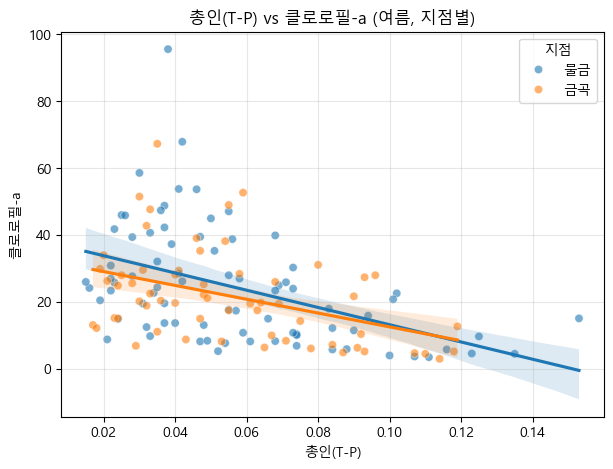

In [59]:
plt.figure(figsize=(7,5))
sb.scatterplot(data=summerDF, x='총인(T-P)', y='클로로필-a', hue='지점', alpha=0.6)

for site in ['물금','금곡']:
    sb.regplot(data=summerDF[summerDF['지점']==site],
                x='총인(T-P)', y='클로로필-a', scatter=False)

plt.title('총인(T-P) vs 클로로필-a (여름, 지점별)')
plt.grid(True, alpha=0.3)
plt.show()


여름철 물금·금곡 모두에서 총인(T-P) 증가가 클로로필-a 감소와 연관되는 음의 추세가 나타나며, 이는 총인 단독 지표의 한계와 유량·수문 영향을 시사한다.

In [60]:
from scipy.stats import ttest_ind

summer = waterDF[waterDF['계절']=='여름']['클로로필-a'].dropna()
nonsummer = waterDF[waterDF['계절']=='비여름']['클로로필-a'].dropna()

t_stat, p_value = ttest_ind(summer, nonsummer, equal_var=False)

print("[전체] 여름 vs 비여름 Welch t-test")
print("여름 평균/표준편차:", len(summer), summer.mean(), summer.std())
print("비여름 평균/표준편차:", len(nonsummer), nonsummer.mean(), nonsummer.std())
print("t-stat:", t_stat)
print("p-value:", p_value)


[전체] 여름 vs 비여름 Welch t-test
여름 평균/표준편차: 140 23.06714285714286 15.831479626797037
비여름 평균/표준편차: 264 21.534848484848485 16.25288268013457
t-stat: 0.9172214309436932
p-value: 0.3597889547474843


In [61]:
for site in ['물금','금곡']:
    tmp = waterDF[waterDF['지점']==site].copy()
    s = tmp[tmp['계절']=='여름']['클로로필-a'].dropna()
    n = tmp[tmp['계절']=='비여름']['클로로필-a'].dropna()
    
    t_stat, p = ttest_ind(s, n, equal_var=False)
    print(f"[{site}] p={p:.5f} | 여름평균={s.mean():.2f} | 비여름평균={n.mean():.2f}")


[물금] p=0.32631 | 여름평균=24.23 | 비여름평균=21.91
[금곡] p=0.83496 | 여름평균=21.56 | 비여름평균=21.08


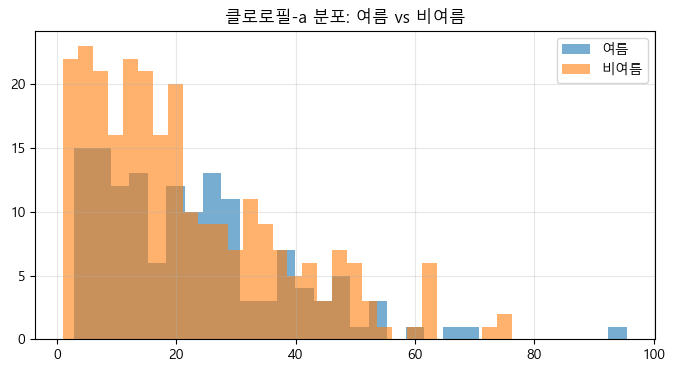

In [62]:
plt.figure(figsize=(8,4))
plt.hist(summer, bins=30, alpha=0.6, label='여름')
plt.hist(nonsummer, bins=30, alpha=0.6, label='비여름')
plt.legend()
plt.title('클로로필-a 분포: 여름 vs 비여름')
plt.grid(True, alpha=0.3)
plt.show()


In [63]:
for site in ['금곡', '물금']:
    tmp = waterDF[waterDF['총량지점명'] == site]
    s = tmp[tmp['계절']=='여름']['클로로필-a'].dropna()
    ns = tmp[tmp['계절']=='비여름']['클로로필-a'].dropna()
    t, p = ttest_ind(s, ns, equal_var=False)
    print(site, p)


금곡 0.8349583682213007
물금 0.326309905636774


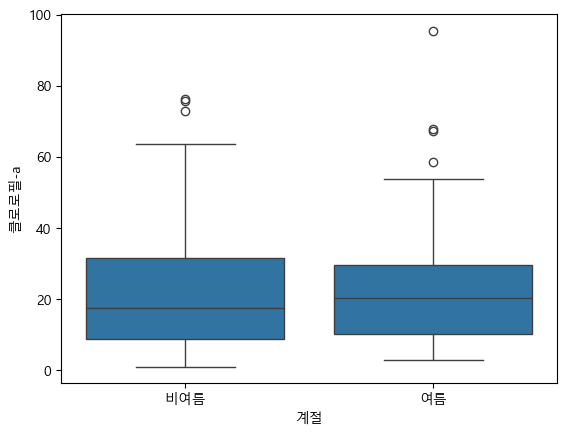

In [64]:
sb.boxplot(data=waterDF, x='계절', y='클로로필-a')
plt.show()

In [65]:
waterDF[['수온','총질소(T-N)','총인(T-P)','클로로필-a']].corr()

,수온,총질소(T-N),총인(T-P),클로로필-a
수온,1.000000,-0.652434,0.280791,0.066079
총질소(T-N),-0.652434,1.000000,0.086836,-0.156235
총인(T-P),0.280791,0.086836,1.000000,-0.126405
클로로필-a,0.066079,-0.156235,-0.126405,1.000000


In [66]:
corr_cols = ['수온', '총질소(T-N)','총인(T-P)', 'BOD', 'COD', '클로로필-a']
corr_df = waterDF[corr_cols].dropna()

corr_df.corr()


,수온,총질소(T-N),총인(T-P),BOD,COD,클로로필-a
수온,1.000000,-0.652434,0.280791,-0.025502,0.590225,0.066079
총질소(T-N),-0.652434,1.000000,0.086836,0.066447,-0.367602,-0.156235
총인(T-P),0.280791,0.086836,1.000000,-0.051870,0.255526,-0.126405
BOD,-0.025502,0.066447,-0.051870,1.000000,0.472863,0.520125
COD,0.590225,-0.367602,0.255526,0.472863,1.000000,0.494771
클로로필-a,0.066079,-0.156235,-0.126405,0.520125,0.494771,1.000000


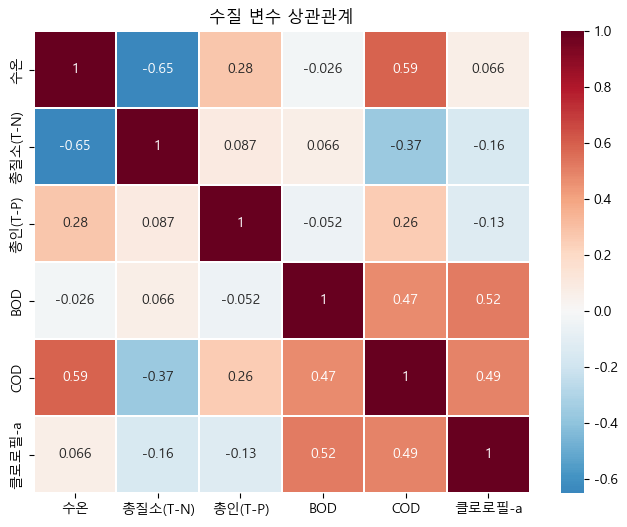

In [67]:
plt.figure(figsize=(8,6))
sb.heatmap(corr_df.corr(), annot=True, linewidths=0.3, cmap='RdBu_r', center=0)
plt.title('수질 변수 상관관계')
plt.show()

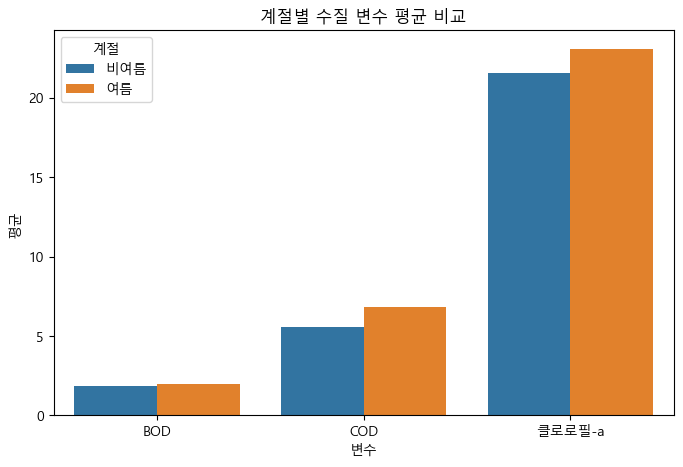

In [68]:
mean_df = waterDF.groupby('계절')[['BOD','COD','클로로필-a']].mean().reset_index()

mean_df_melt = mean_df.melt(id_vars='계절',
                            value_vars=['BOD','COD','클로로필-a'],
                            var_name='변수',
                            value_name='평균')

plt.figure(figsize=(8,5))
sb.barplot(data=mean_df_melt, x='변수', y='평균', hue='계절')
plt.title('계절별 수질 변수 평균 비교')
plt.show()

“계절별 평균 비교 결과, 여름철에 BOD와 COD의 증가는 제한적인 반면, 클로로필-a는 상대적으로 큰 폭으로 증가하여 녹조 발생이 계절적 환경 요인에 의해 크게 증폭됨을 확인하였다.”

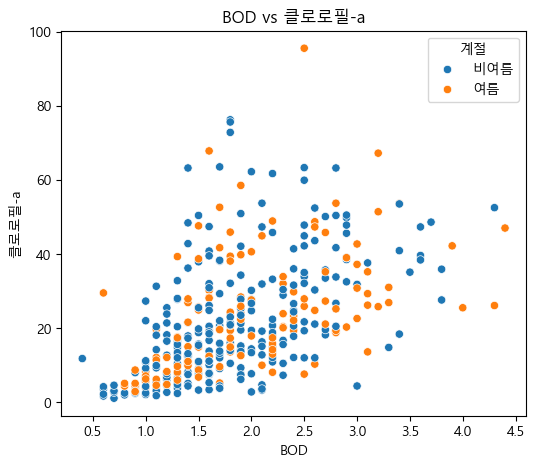

In [69]:
plt.figure(figsize=(6,5))
sb.scatterplot(data=waterDF, x='BOD', y='클로로필-a', hue='계절')
plt.title('BOD vs 클로로필-a')
plt.show()


“BOD와 클로로필-a 간의 양의 관계는 계절과 무관하게 유지되었으며, 여름철에는 동일한 BOD 수준에서도 더 높은 클로로필-a 농도가 관측되어 계절 요인이 관계를 증폭시키는 것으로 나타났다.”

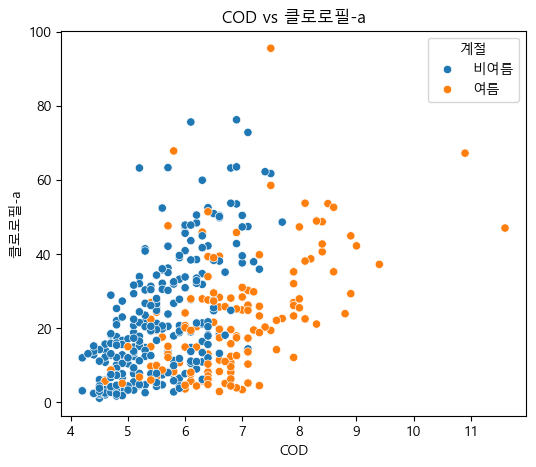

In [70]:
plt.figure(figsize=(6,5))
sb.scatterplot(data=waterDF, x='COD', y='클로로필-a', hue='계절')
plt.title('COD vs 클로로필-a')
plt.show()


“COD와 클로로필-a 간의 관계는 계절에 따라 상이하게 나타났으며, 여름철에만 상대적으로 높은 클로로필-a 농도가 관측되었다. 이는 COD가 조류 증식을 직접적으로 설명하기보다는 계절적 조건 하에서 보조적 역할을 수행함을 시사한다.”

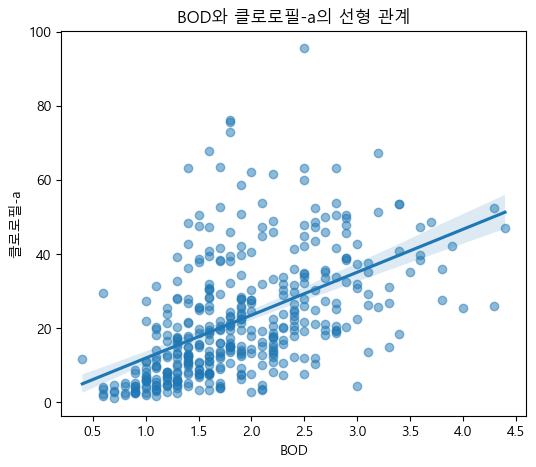

In [71]:
plt.figure(figsize=(6,5))
sb.regplot(data=waterDF, x='BOD', y='클로로필-a', scatter_kws={'alpha':0.5})
plt.title('BOD와 클로로필-a의 선형 관계')
plt.show()


“전체 자료를 통합한 분석 결과, BOD와 클로로필-a 사이에는 통계적으로 안정적인 양의 선형 관계가 확인되었으며, 이는 지점 구분과 무관하게 유기물 오염이 조류 증식과 밀접히 연관됨을 시사한다.”

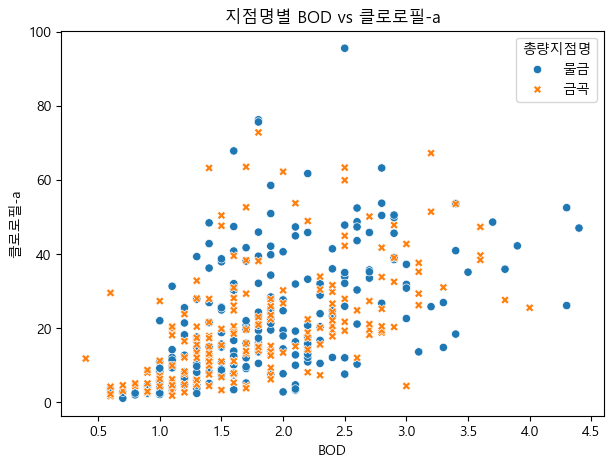

In [72]:
site_df = waterDF[waterDF['총량지점명'].isin(['금곡','물금'])]

plt.figure(figsize=(7,5))
sb.scatterplot(
    data=site_df,
    x='BOD',
    y='클로로필-a',
    hue='총량지점명',
    style='총량지점명'
)
plt.title('지점명별 BOD vs 클로로필-a')
plt.show()


“BOD 증가에 따라 클로로필-a 농도의 상한과 평균이 함께 증가하는 경향이 뚜렷하게 나타났으며, 특히 BOD 2 mg/L 이상 구간에서 녹조 발생 위험이 급격히 증가하는 분포 특성이 확인되었다.”

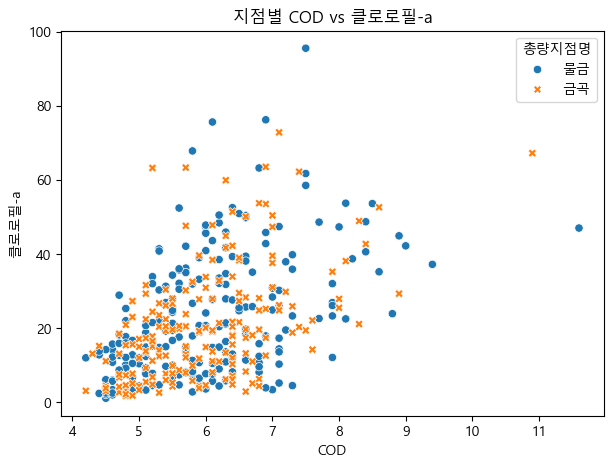

In [73]:
plt.figure(figsize=(7,5))
sb.scatterplot(
    data=site_df,
    x='COD',
    y='클로로필-a',
    hue='총량지점명',
    style='총량지점명'
)
plt.title('지점별 COD vs 클로로필-a')
plt.show()


“COD와 클로로필-a 간에는 약한 양의 경향은 관찰되었으나, 분산이 매우 커 선형적 관계는 뚜렷하지 않았다. 이는 COD가 난분해성 유기물을 포함하는 지표로서, 조류 증식과의 직접적 연관성이 제한적임을 시사한다.”

<Figure size 700x500 with 0 Axes>

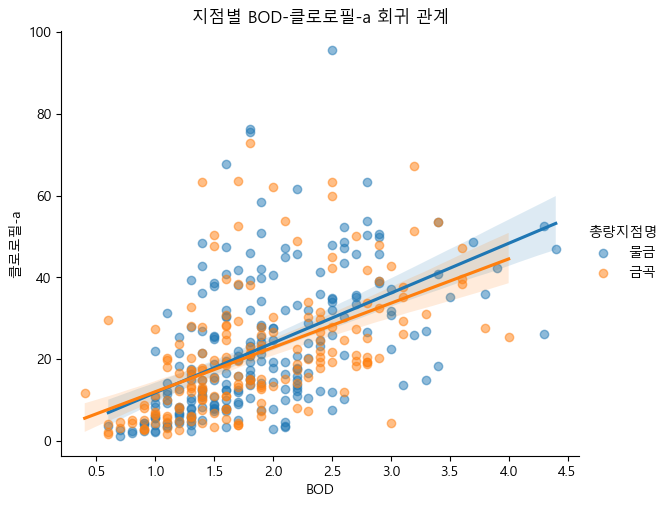

In [74]:
plt.figure(figsize=(7,5))
sb.lmplot(
    data=site_df,
    x='BOD',
    y='클로로필-a',
    hue='총량지점명',
    height=5,
    aspect=1.2,
    scatter_kws={'alpha':0.5}
)
plt.title('지점별 BOD-클로로필-a 회귀 관계')
plt.show()


“여름철 물금·금곡 지점 모두에서 BOD와 클로로필-a 간에 뚜렷한 양의 상관관계가 확인되었으며, 이는 유기물 오염 증가가 조류 증식을 동반함을 시사한다. 특히 물금 지점에서 그 반응 강도가 더 크게 나타났다.”